In [1]:
from __future__ import unicode_literals
import re
from decouple import config
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn

In [2]:
connection_string = config('MONGO_CONNECTION_STRING')
client = MongoClient(connection_string)
db = client.db
coll = db['twitter']

In [3]:
pipeline = [
    {
        "$project": {
            "_id": 0,
            "uid": "$user.id",
            "user": "$user.name",
            "screen_name": "$user.screen_name",
            "user_desc": "$user.description",
            "verified": "$user.verified",
            "followers": "$user.followers_count"
        }
    },
    {
        "$sort": {
            "user": 1
        }
    }
]
# sorting by uid will inadvertently filter by date joined, putting established accts first

In [4]:
df = pd.DataFrame.from_dict(list(coll.aggregate(pipeline)))
df.head()

,uid,user,screen_name,user_desc,verified,followers
0,807034969902252032,"""MRH_1984"" 🇨🇦",MRH_1984,🇨🇦 Not Politically Correct. Libtards=Mute/Bloc...,False,2480
1,942083635808792576,#AnitasAffordableBookstore,AABookstore,https://t.co/ATupVUkbR4… Amazon https://t.co/m...,False,529
2,942083635808792576,#AnitasAffordableBookstore,AABookstore,https://t.co/ATupVUkbR4… Amazon https://t.co/m...,False,529
3,942083635808792576,#AnitasAffordableBookstore,AABookstore,https://t.co/ATupVUkbR4… Amazon https://t.co/m...,False,529
4,942083635808792576,#AnitasAffordableBookstore,AABookstore,https://t.co/ATupVUkbR4… Amazon https://t.co/m...,False,529


In [5]:
df.drop_duplicates(subset=['uid'], keep='first', inplace=True)
df.head()

,uid,user,screen_name,user_desc,verified,followers
0,807034969902252032,"""MRH_1984"" 🇨🇦",MRH_1984,🇨🇦 Not Politically Correct. Libtards=Mute/Bloc...,False,2480
1,942083635808792576,#AnitasAffordableBookstore,AABookstore,https://t.co/ATupVUkbR4… Amazon https://t.co/m...,False,529
13,1207754603673972736,#BCPoliTalk,bcpolitalk,We talk politics in British Columbia. Hosted b...,False,206
15,2518034430,#FreeChelseaManning & #PrayForAmazonas,JJacobMarion,"Aging, pseudo-intellectual twink with abandonm...",False,163
16,38458897,#IndianStatus531,BlueCedarAngel,Gitxsan Nation; FireWeed tribe; House of Woo's...,False,1228


In [7]:
from sklearn.pipeline import Pipeline

# Tutorials:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [8]:
corpus = list(df['user_desc'])

In [9]:
# Remove URL junk
url_pattern = re.compile("http[^\s]+", re.I)

for i in range(len(corpus)):
    corpus[i] = url_pattern.sub('', corpus[i])

In [10]:
corpus[:5]

['🇨🇦 Not Politically Correct. Libtards=Mute/Block\n "Orwell\'s 1984 is Upon Us"....',
 ' Amazon  Smashwords  @LlewelynPritch   ...Twitter',
 "We talk politics in British Columbia. Hosted by @billtieleman and Daniel Fontaine. #bcpoli #BCPoliTalk\n\nWe're a Partnered Program of @CTMinBC.",
 'Aging, pseudo-intellectual twink with abandonment issues. Failed Youtuber. Author. Patrons get my books for free! 🏳️\u200d🌈🇨🇦 (He/Him/His)',
 "Gitxsan Nation; FireWeed tribe; House of Woo'sim'la’ha’; Crest 2 baby white owls; #LawsOfMatriach\nHuman in a woman's body"]

In [11]:
non_ascii_pattern = re.compile("[^\u0000-\u2300]") # source https://stackoverflow.com/questions/2124010/grep-regex-to-match-non-ascii-characters
# ellipsis: "\u2026"; currency symbols later

for i in range(200):
    if non_ascii_pattern.search(corpus[i]):
        print((non_ascii_pattern.findall(corpus[i])[0]))

🇨
🏳
😲
💞
👊
🚫
🥔
🌅
📷
📺
👥
🍁
🍁
🇨
🌱
💗
💙
🌈
🇨
🌈
🎙
💪
✝
🏳
🍁
🖤
🌲
😁
🍁
❤
🇮
♥


In [12]:
for i in range(len(corpus)):
    corpus[i] = non_ascii_pattern.sub('', corpus[i])

In [99]:
matrix = TfidfVectorizer(strip_accents='unicode',
                          analyzer='word',
                          stop_words='english',
                          ngram_range=(1,2))
X = matrix.fit_transform(corpus)

In [100]:
terms = matrix.get_feature_names()
print("N-grams:", len(terms))

N-grams: 23620


In [101]:
# Dimensionality reduction for latent semantic analysis
svd = TruncatedSVD(n_components=100) # Recommended param for TfIdf matrix
normalizer = Normalizer(copy=False)
lsa = Pipeline([
    ('truncated_SVD', svd), 
    ('normalizer', normalizer)
    ])

In [102]:
matrix = lsa.fit_transform(X)

In [103]:
# Choose number of clusters for unclassified data
# Close to 0 indicates overlap; close to 1 indicates dense, separate clusters
# https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

for n_clusters in range(2,20):
    km_comp = KMeans(n_clusters=n_clusters, random_state=1)
    km_comp.fit(matrix)
    print("%d\t Silhouette coefficient: %0.3f" % (n_clusters,
                                              metrics.silhouette_score(matrix, km_comp.labels_)))

2	 Silhouette coefficient: 0.036
3	 Silhouette coefficient: 0.032
4	 Silhouette coefficient: 0.038
5	 Silhouette coefficient: 0.039
6	 Silhouette coefficient: 0.032
7	 Silhouette coefficient: 0.035
8	 Silhouette coefficient: 0.045
9	 Silhouette coefficient: 0.043
10	 Silhouette coefficient: 0.049
11	 Silhouette coefficient: 0.027
12	 Silhouette coefficient: 0.050
13	 Silhouette coefficient: 0.035
14	 Silhouette coefficient: 0.036
15	 Silhouette coefficient: 0.053
16	 Silhouette coefficient: 0.055
17	 Silhouette coefficient: 0.054
18	 Silhouette coefficient: 0.050
19	 Silhouette coefficient: 0.049


In [83]:
km = KMeans(4) # default: n_clusters=8, max_iter=300, n_init=10

In [84]:
km.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [85]:
# with SVD
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
# without SVD
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(km.n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :15]:
            print('   %s' % terms[ind], end='')
        print('\n')

Cluster 0:   canadian   canada   politics   opinions   political   people   tweets   life   make   bc   love   anti   public   student   policy

Cluster 1:   justice   climate   social   social justice   climate justice   change   environmental   climate change   activist   environmental justice   advocate   director   energy   grassroots   campaigner

Cluster 2:   indigenous   writer   artist   activist   lover   free   author   educator   music   settler   poet   journalist   time   live   new

Cluster 3:   news   breaking   breaking news   canada   source   analysis   news analysis   politics   city news   follow   global   local   city   media   reporter



In [86]:
labels = km.labels_.tolist() # [0,1,2...]

In [87]:
pd.set_option("display.max_colwidth", 200)

km_df_cols = {'user': df['user'], 'user_desc': df['user_desc'], 
              'followers': df['followers'], 'verified': df['verified'], 'label': labels}
km_df = pd.DataFrame(km_df_cols)
km_df.reset_index(inplace=True)
km_df.head()

,index,user,user_desc,followers,verified,label
0,0,"""MRH_1984"" 🇨🇦","🇨🇦 Not Politically Correct. Libtards=Mute/Block\n ""Orwell's 1984 is Upon Us""....",2480,False,0
1,1,#AnitasAffordableBookstore,https://t.co/ATupVUkbR4… Amazon https://t.co/mMOE5pemq5… Smashwords @LlewelynPritch ...Twitter,529,False,0
2,13,#BCPoliTalk,We talk politics in British Columbia. Hosted by @billtieleman and Daniel Fontaine. #bcpoli #BCPoliTalk\n\nWe're a Partnered Program of @CTMinBC.,206,False,0
3,15,#FreeChelseaManning & #PrayForAmazonas,"Aging, pseudo-intellectual twink with abandonment issues. Failed Youtuber. Author. Patrons get my books for free! 🏳️‍🌈🇨🇦 (He/Him/His)",163,False,2
4,16,#IndianStatus531,Gitxsan Nation; FireWeed tribe; House of Woo'sim'la’ha’; Crest 2 baby white owls; #LawsOfMatriach\nHuman in a woman's body,1228,False,2


In [88]:
grouped = km_df.groupby(km_df['label'])
grouped.size() # members in each group

label
0    1122
1     131
2     548
3     112
dtype: int64

In [89]:
pca = PCA(n_components=2)

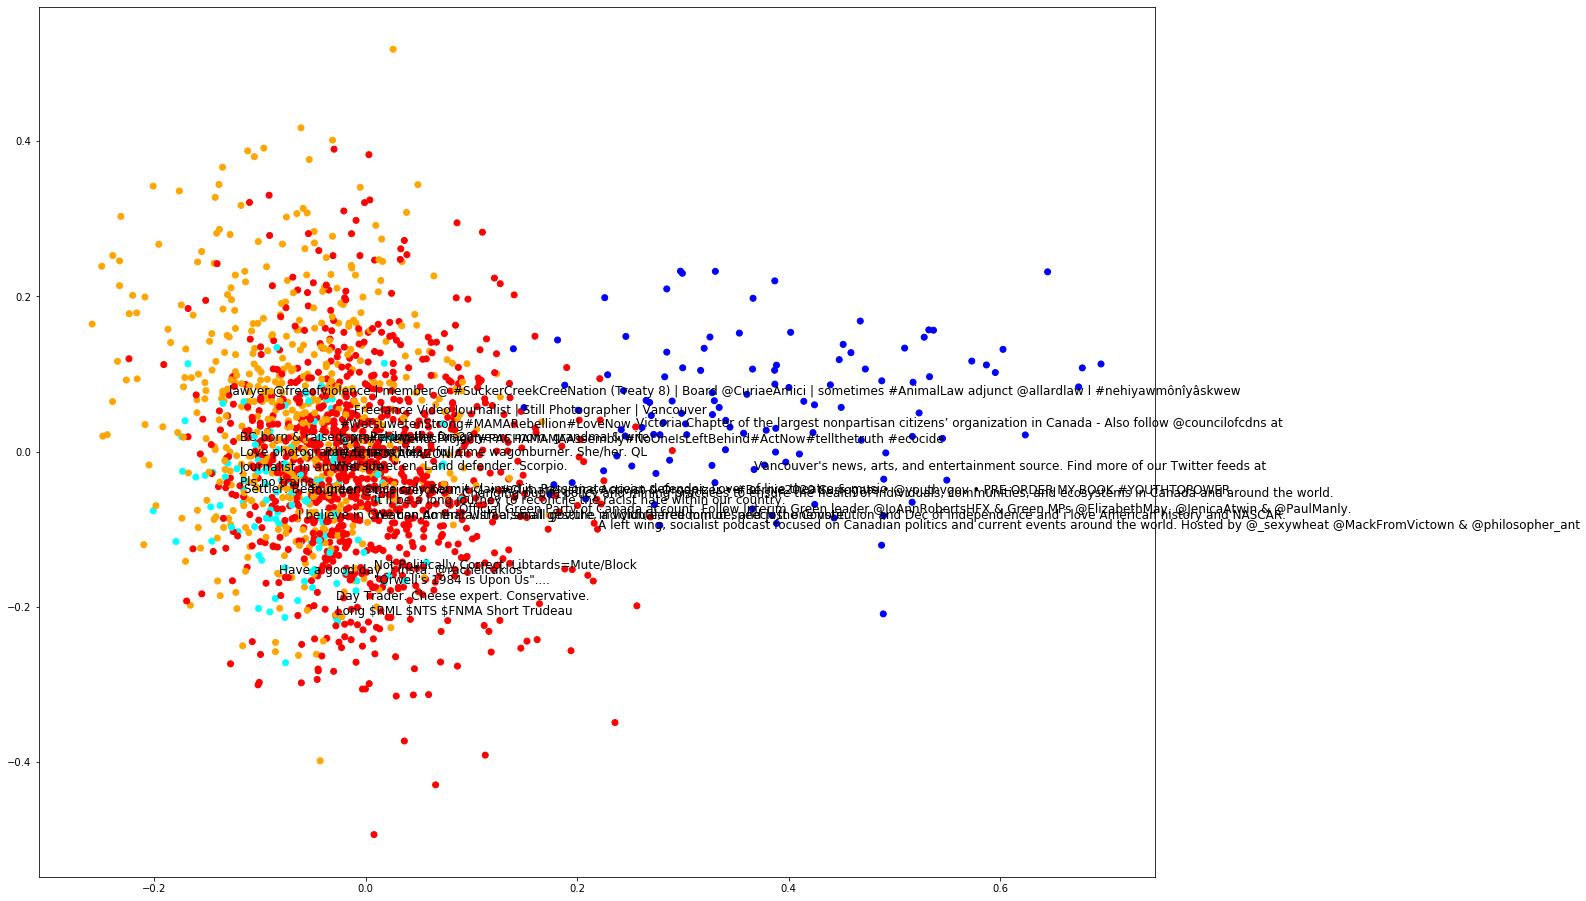

In [90]:
scatter_plot_points = pca.fit_transform(matrix)

colors = ["red", "cyan", "orange", "blue"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,16))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in km.labels_])

for i, txt in enumerate(corpus):
    if i % 90 != 0:
        continue
    ax.annotate(txt, xy=(x_axis[i], y_axis[i]),
                size=12)